In [ ]:
# Import libraries

import random
import math
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from collections import deque

import keras

<ipython-input-1-1a5193c3ceca>:7: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


# 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Movies
movies = pd.read_csv('/content/drive/MyDrive/Studium/MAI/Data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Load Ratings
ratings = pd.read_csv('/content/drive/MyDrive/Studium/MAI/Data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
# Find user with the highest amount of ratings
ratings.userId.mode()


,userId
0,72315


In [ ]:
import pandas as pd

# Load your ratings and movies data
ratings = pd.read_csv('/content/drive/MyDrive/Studium/MAI/Data/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/Studium/MAI/Data/movies.csv')  # Should contain movieId, title, and genres

# Merge on movieId to get genre information in ratings DataFrame
ratings = ratings.merge(movies[['movieId', 'genres']], on='movieId', how='left')


In [ ]:
# Provide all possible genres
allGenres = [
               "Adventure",
               "Action",
               "Animation",
               "Children",
               "Comedy",
               "Crime",
               "Documentary",
               "Drama",
               "Fantasy",
               "Film-Noir",
               "Horror",
               "Musical",
               "Mystery",
               "Romance",
               "Sci-Fi",
               "Thriller",
               "War",
               "Western"
]

# 2. Process Data

In [ ]:
# Initialize data processing methods

def getMoviesByGenre(handle):
  movies[handle] = movies['genres'].str.contains(handle)
  moviesByGenre = movies[movies[handle] == True]
  return moviesByGenre

def getRatingsByGenre(handle):
  ratings[handle] = ratings['genres'].str.contains(handle)
  ratingsByGenre = ratings[ratings[handle] == True]
  return ratingsByGenre

def getGenreMean(handle):
  return ratings.loc[ratings[handle] == True, 'rating'].mean()

def getMaxInList(maxMeans):
  return np.where(maxMeans == np.nanmax(maxMeans))

def identifyMaxGenres(maxMeans, userId):
  result = []
  for index in maxMeans:
    userMax = np.array(np.array(allGenres)[index])
    userMax = np.insert(userMax, 0, userId, axis=0)
    result.append(userMax)
  return result

In [ ]:
# Add genre boolean for each movie

for genre in allGenres:
  getMoviesByGenre(genre)

print("Updated movie columns!")
movies.head()

Updated movie columns!


,movieId,title,genres,Adventure,Action,Animation,Children,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,True,False,True,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),Adventure|Children|Fantasy,True,False,False,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),Comedy|Romance,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II (1995),Comedy,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
ratings['userId'].value_counts()[40:150]

,count
userId,
2177,4227
123711,4135
61412,4109
18306,4086
60655,4035
...,...
51238,2874
133681,2873
45394,2863


In [ ]:
# Add genre boolean for each rating
for genre in allGenres:
  getRatingsByGenre(genre)

print("Updated genre columns!")
ratings.head()

Updated genre columns!


,userId,movieId,rating,timestamp,genres,Adventure,Action,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,1147880044,Comedy|Crime|Drama|Thriller,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
1,1,306,3.5,1147868817,Drama,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,307,5.0,1147868828,Drama,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,665,5.0,1147878820,Comedy|Drama|War,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
4,1,899,3.5,1147868510,Comedy|Musical|Romance,False,False,False,False,True,...,False,False,False,True,False,True,False,False,False,False


In [ ]:
# Create [genre, action] sequence (each pair will be one episode)

## Choose user from dataset
startAt = 3 # User ID
userAmount = 1

userSequencePool = []

for user in range(startAt, startAt + userAmount):
  userRatingSequence = []
  unsortedUserRatings = ratings[ratings['userId'] == user]
  userRatings = unsortedUserRatings.sort_values(by=['timestamp'])

  # Create actions from ratings
  for i, rating in userRatings.iterrows():
    # Neutral
    observation = [rating['genres'], 0]

    # Positive
    if int(rating['rating']) >= 4.0:
      observation = [rating['genres'], 2]

    # Negative
    if int(rating['rating']) <= 2.0:
      observation = [rating['genres'], 1]

    userRatingSequence.append(observation)

  userSequencePool.append(userRatingSequence)

print('Number of ratings: %s' % (len(userSequencePool[0])))
print('Example of the appearance of one rating: %s' % userSequencePool[0][0])

Number of ratings: 656
Example of the appearance of one rating: ['Comedy|Drama|Romance|War', 2]


# 3. Analyse Data

### 3.1 Create Environment

In [ ]:
# Create atrificial environment

class Environment:
  def __init__(self, user, action_space):

    self.state = np.zeros(action_space)
    self.user = user

  # Calculate reward for the given action of an episode
  def episode(self, step, action):
    correctlyPredicted = False
    currentUser = np.array(userSequencePool)[self.user]

    reward = -0.025

    for i, genre in enumerate(allGenres):
      if genre in currentUser[step][0] and i == action:
        correctlyPredicted = True

    if correctlyPredicted:
      # Neutral
      reward = 0.1

      # Positive
      if int(currentUser[step][1]) == 2:
        reward = 0.3

      # Negative
      if int(currentUser[step][1]) == 1:
        reward = -0.2

    return reward, currentUser[step]

  # Simulate the change of the environment
  def update_state(self, currentRating, reward):
    for i, genre in enumerate(allGenres):
      if genre in currentRating:
        self.state[i] += reward


### 3.2 Create Agent

In [ ]:
import numpy as np
from collections import deque
from tensorflow import keras

class Agent:
    def __init__(self, action_space, data):
        self.data = data
        self.data_length = len(self.data)
        self.action_space = action_space
        self.action_count = np.zeros(action_space)

        self.epsilon = 0.3
        self.learning_rate = 0.1
        self.discount_factor = 0.01
        self.batch_size = 32

        self.model = self.build_model()
        self.memory = deque(maxlen=100000)
        self.acc = []
        self.loss = []

    # Memorize current episode
    def remember(self, reward, action, state, next_state, done):
        self.memory.append((state, action, reward, done, next_state))

    # Create model
    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(64, input_shape=(self.action_space,), activation='relu'))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(self.action_space, activation='linear'))
        # Updated optimizer line
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), metrics=['accuracy'])
        return model

    # Predict action from current state
    def act(self, state):
        # Epsilon greedy for exploration vs. exploitation dilemma
        exploration = (np.random.uniform(0,1) < self.epsilon)

        if exploration:
            action = np.random.randint(self.action_space)
        else:
            prediction = self.model.predict(state)
            action = np.argmax(prediction)

        self.action_count[action] += 1
        return action

    # Train Neural Network
    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Create Training Data
        minibatch = list(self.memory)[-self.batch_size:]
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[4] for i in minibatch])
        dones = np.array([i[3] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        # Q-Algorithm to learn
        targets = np.amax(states) - self.learning_rate * (rewards + self.discount_factor * np.amax(self.model.predict_on_batch(next_states), axis=1) - np.amax(states))
        targets_full = self.model.predict_on_batch(states)

        # Map updated q_values to action_space
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        # Train model with state and action_space of each memorized episode in batch
        history = self.model.fit(states, targets_full, epochs=1, verbose=0)
        self.loss.append(history.history['loss'][0])
        self.acc.append(history.history['accuracy'][0])


### 3.3 Run Reinforcement Learning System

In [ ]:
action_space = 18
state_space = 18
user_index = 0

genreRewards = []


# Initialize Environment & Agent
env = Environment(user_index, action_space)
agent = Agent(action_space, userSequencePool[user_index])

for currentRating in range(len(userSequencePool[user_index])):
  isDone = True if currentRating == len(userSequencePool[user_index]) - 1 else False

# # Act
  ## Predict next possible user action
  action = agent.act(np.reshape(env.state, (1, state_space)))
  ## Observe action and generate reward
  reward, currentUser = env.episode(currentRating, action)
  genreRewards.append([action, reward])

# # Update environment
  ## Save current state
  state = env.state
  ## Update the environment with current reward
  env.update_state(currentUser[0], reward)
  ## Save next_state
  next_state = env.state

# # Remember this episode
  agent.remember(reward, action, state, next_state, isDone)

# # Train the neural network
  agent.train()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

# 4. Visualize Results

#### 4.1 Comparison of actual vs maximum rewards.

In [ ]:
def sortGenresByMean(meanValues):
  return np.array(meanValues).argsort()[-len(meanValues):][::-1]

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
<ipython-input-52-f49143d3183e>:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  significanceValues.append(pearsonr(maximumCorrelationValues[corrValueIndex], actualCorrelationValues[corrValueIndex]))


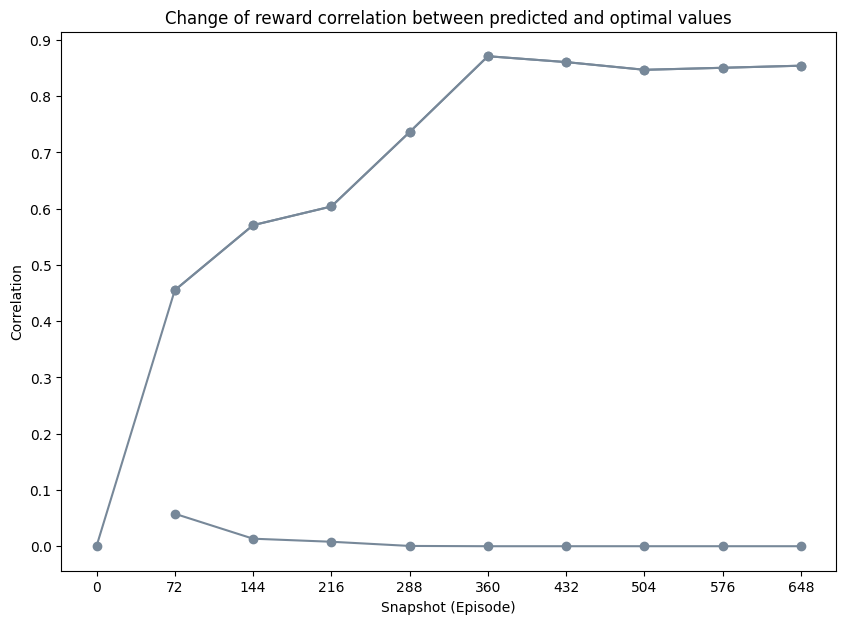

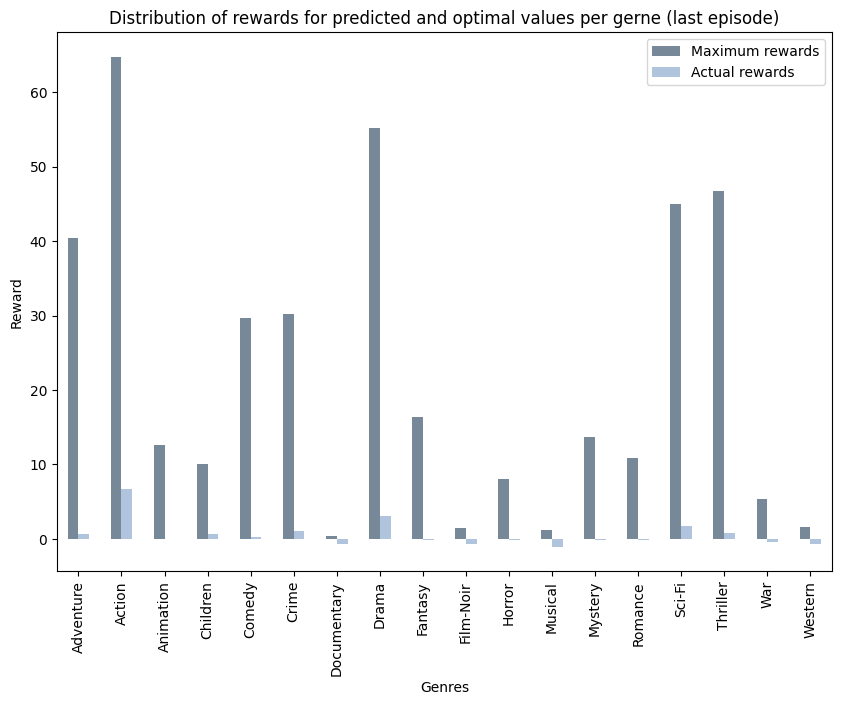

In [ ]:
snapshots = 9
dataStep = math.floor(len(userSequencePool[user_index]) / snapshots)
maximumCorrelationValues = []
actualCorrelationValues = []

# Maximum rewards per genre
maximumRewardsSum = np.zeros(18)
for ratingIndex, rating in enumerate(userSequencePool[user_index]):
  if ratingIndex % dataStep == 0:
    maximumCorrelationValues.append(np.array(maximumRewardsSum))
  for i, genre in enumerate(allGenres):
    if genre in rating[0]:
      if rating[1] == 2:
        maximumRewardsSum[i] += 0.3

      if rating[1] == 1:
        maximumRewardsSum[i] -= 0

      if rating[1] == 0:
        maximumRewardsSum[i] += 0.1

# Actual rewards per genre
actualRewardsSum = np.zeros(18)
rewardsOverTime = []
for ratingIndex, pair in enumerate(genreRewards):
  if ratingIndex % dataStep == 0:
    actualCorrelationValues.append(np.array(actualRewardsSum))
  rewardsOverTime.append(pair[1])
  actualRewardsSum[pair[0]] += pair[1]

# Correlation analysis
correlationValues = []
significanceValues = []
for corrValueIndex, corrValue in enumerate(maximumCorrelationValues):
  correlationValues.append(np.corrcoef(maximumCorrelationValues[corrValueIndex], actualCorrelationValues[corrValueIndex])[0][1])
  significanceValues.append(pearsonr(maximumCorrelationValues[corrValueIndex], actualCorrelationValues[corrValueIndex]))

correlationValues = np.where(np.isnan(correlationValues), 0, correlationValues)
labels = [i * dataStep for i in range(0, snapshots+1)]

plt.figure(figsize=(10,7))
plt.xlabel("Snapshot (Episode)")
plt.ylabel("Correlation")
plt.xticks(np.arange(0, snapshots+1), labels)
plt.yticks(np.arange(0, 1, step=0.1))
plt.plot(correlationValues, marker='o', color="lightslategrey")
plt.plot(significanceValues, marker='o', color="lightslategrey")
plt.title("Change of reward correlation between predicted and optimal values")

# Plot
groupedData = pd.DataFrame(np.c_[maximumRewardsSum, actualRewardsSum], index=allGenres)
ax = groupedData.plot.bar(
    figsize=(10,7),
    xlabel="Genres",
    ylabel="Reward",
    title="Distribution of rewards for predicted and optimal values per gerne (last episode)",
    color=["lightslategrey", "lightsteelblue"]
)
ax.legend(["Maximum rewards", "Actual rewards"]);

In [ ]:
print('\n\nMaximum Ranking:\n')
sortedGenreByMaximumReward = sortGenresByMean(maximumRewardsSum)
for i, genreIndex in enumerate(sortedGenreByMaximumReward):
  print('%s: %s' % (i +1, allGenres[genreIndex]))



Maximum Ranking:

1: Action
2: Drama
3: Thriller
4: Sci-Fi
5: Adventure
6: Crime
7: Comedy
8: Fantasy
9: Mystery
10: Animation
11: Romance
12: Children
13: Horror
14: War
15: Western
16: Film-Noir
17: Musical
18: Documentary


In [ ]:
print('\n\nActual Ranking:\n')
sortedGenreByActualReward = sortGenresByMean(actualRewardsSum)
for i, genreIndex in enumerate(sortedGenreByActualReward):
  print('%s: %s' % (i +1, allGenres[genreIndex]))



Actual Ranking:

1: Action
2: Drama
3: Sci-Fi
4: Crime
5: Thriller
6: Adventure
7: Children
8: Comedy
9: Animation
10: Fantasy
11: Mystery
12: Romance
13: Horror
14: War
15: Documentary
16: Film-Noir
17: Western
18: Musical


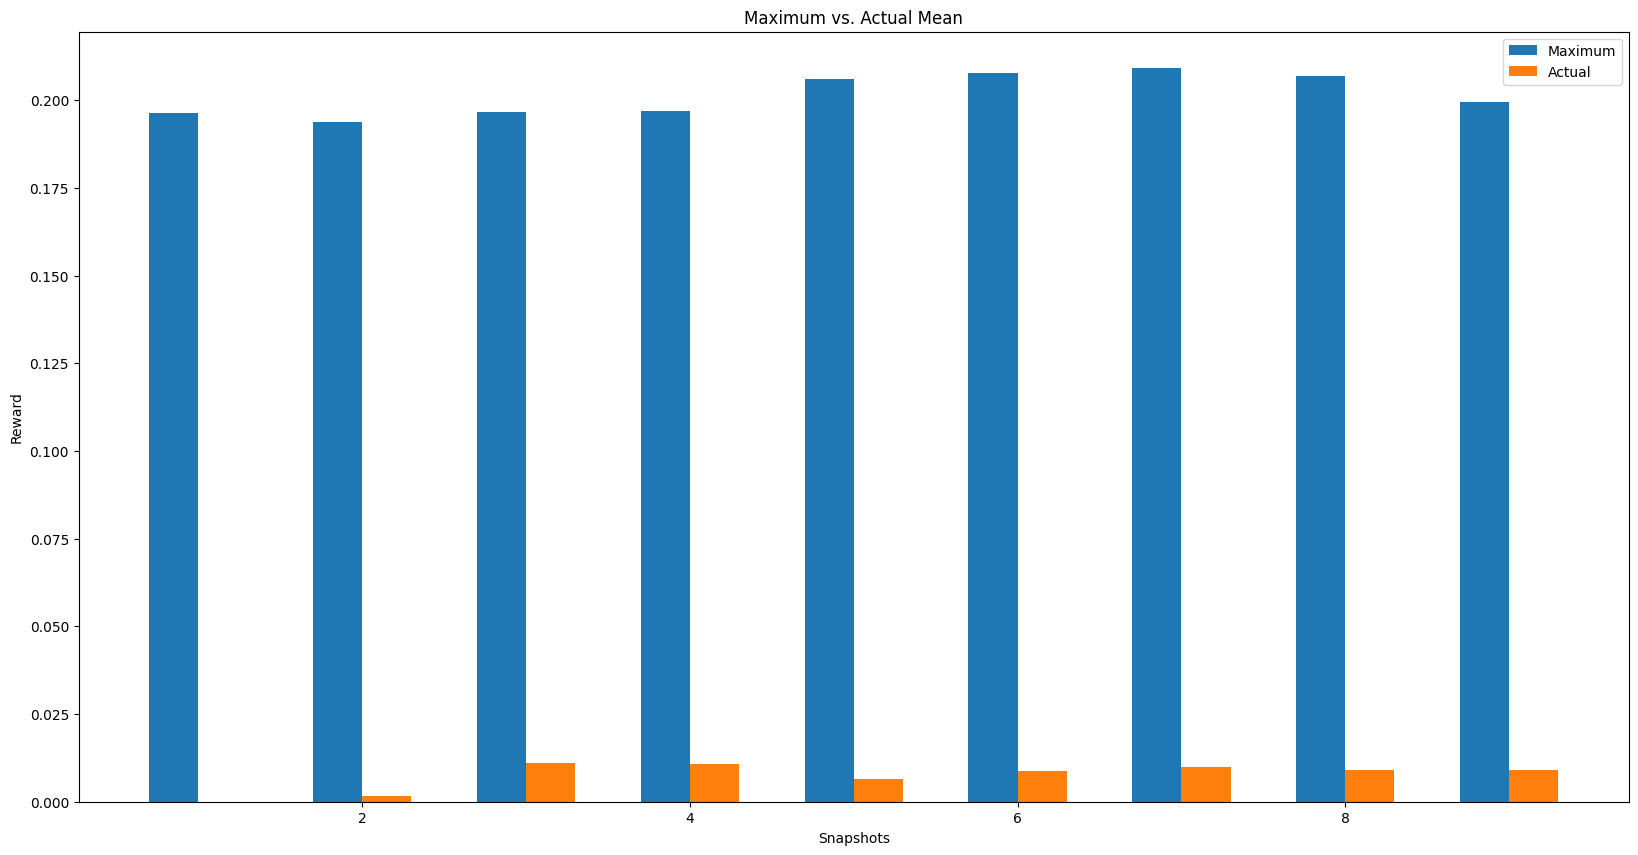

In [ ]:
def mapRatingsToEpisodes(ratings):
  for genreIndex, array in enumerate(ratings):
    arraySteps = list(range(0, len(genreRewards)))
    currentGenreDevelopment = np.zeros(len(genreRewards))
    increment = 0
    for j, value in enumerate(currentGenreDevelopment):
      for val in array:
        if val[0] == j:
          increment = val[1]
      currentGenreDevelopment[j] = increment
    ratings[genreIndex] = currentGenreDevelopment
  return ratings

def createGenreMeanValues(ratingsPerGenre, step):
  allGenreMeanValues = [[] for i in allGenres]
  for genreIndex, genre in enumerate(ratingsPerGenre):
    genreMeanValues = []
    for episodeIndex, episode in enumerate(genre):
      snapshot = episodeIndex + 1
      if snapshot % step == 0:
        genreMeanValues.append(np.mean(genre[:episodeIndex]))
    allGenreMeanValues[genreIndex].append(genreMeanValues)
  return allGenreMeanValues


def sumMeanValuesPerStep(rewards):
  sumMeanValuesPerSnapshot = [[] for snapshot in range(0, snapshots)]
  for snapshotIndex, snapshot in enumerate(range(0, snapshots)):
    for genreIndex, genre in enumerate(allGenres):
      sumMeanValuesPerSnapshot[snapshotIndex].append(rewards[genreIndex][0][snapshotIndex])
  return [np.mean(item) for item in sumMeanValuesPerSnapshot]


actualRewards = [[] for i in allGenres]
maximumRewards = [[] for i in allGenres]
snapshots = 9
dataStep = math.floor(len(userSequencePool[user_index]) / snapshots)

# Maximum rewards per genre
for ratingIndex, rating in enumerate(userSequencePool[user_index]):
  for genreIndex, genre in enumerate(allGenres):
      if genre in rating[0]:
        if rating[1] == 2:
          maximumRewards[genreIndex].append([ratingIndex, 0.3])

        if rating[1] == 1:
          maximumRewards[genreIndex].append([ratingIndex, 0])

        if rating[1] == 0:
          maximumRewards[genreIndex].append([ratingIndex, 0.1])

# Actual rewards per genre
for i, pair in enumerate(genreRewards):
  actualRewards[pair[0]].append([i, pair[1]])

maximumRewards = mapRatingsToEpisodes(maximumRewards)
actualRewards = mapRatingsToEpisodes(actualRewards)

maximumRewards = createGenreMeanValues(maximumRewards, dataStep)
actualRewards = createGenreMeanValues(actualRewards, dataStep)

maximumRewards = sumMeanValuesPerStep(maximumRewards)
actualRewards = sumMeanValuesPerStep(actualRewards)

x = np.arange(np.array(snapshots))
width = 0.3
plt.figure(figsize=(20,10))
plt.xlabel("Snapshots")
plt.ylabel("Reward")
plt.title("Maximum vs. Actual Mean")

plt.bar(x - width/2 + 1, np.array(maximumRewards), width=width, label="Maximum")
plt.bar(x + width/2 + 1, np.array(actualRewards), width=width, label="Actual")

plt.legend()
plt.show()

#### 4.2 Genre reward sum per episode

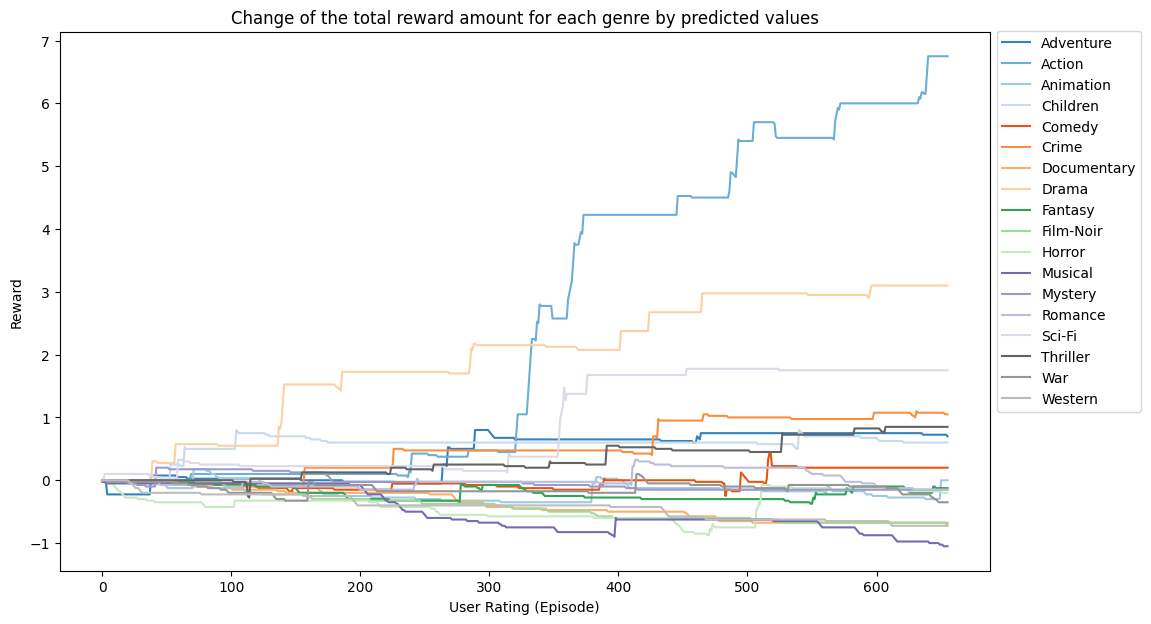

In [ ]:
numColors = len(allGenres)
cm = plt.get_cmap('tab20c')
genreChange = [[] for i in allGenres]
for ratingIndex, genreRewardPair in enumerate(genreRewards):
  genreChange[genreRewardPair[0]].append([ratingIndex, genreRewardPair[1]])

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
plt.xlabel("User Rating (Episode)")
plt.ylabel("Reward")
plt.title("Change of the total reward amount for each genre by predicted values")
ax.set_prop_cycle('color', [cm(1.*i/numColors) for i in range(numColors)])

for genre, array in enumerate(genreChange):
  arraySteps = list(range(0, len(genreRewards)))
  currentGenreChange = np.zeros(len(genreRewards))
  increment = 0
  for j, value in enumerate(currentGenreChange):
    for val in array:
      if val[0] == j:
        increment += val[1]
    currentGenreChange[j] = increment
  ax.plot(arraySteps, currentGenreChange, label=allGenres[genre])
ax.legend(bbox_to_anchor=(1, 1.015), loc='upper left')

#### 4.3 Genre reward sum distribution per episode

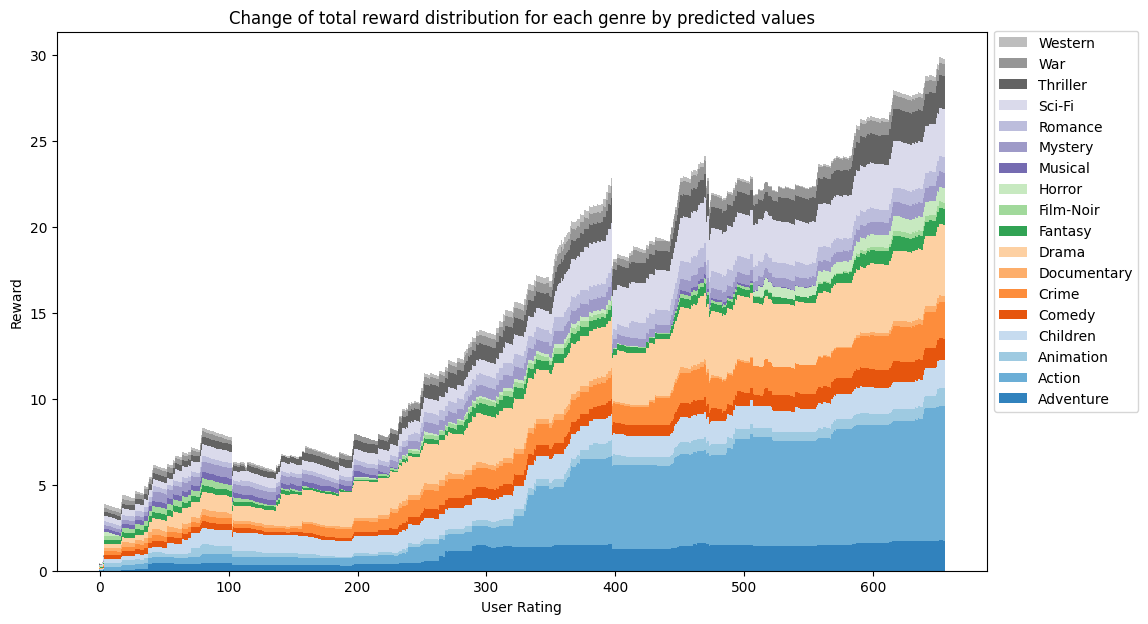

In [ ]:
def getPositiveValues(val):
  return (-1) * val

numColors = len(allGenres)
cm = plt.get_cmap('tab20c')
genresStacked = []
genreDevelopment = [[] for i in allGenres]
genresStackedNormalized = [[] for i in allGenres]
episodeMins = list(np.zeros(len(genreRewards)))

for i, pair in enumerate(genreRewards):
  genreDevelopment[pair[0]].append([i, pair[1]])

for genre, array in enumerate(genreDevelopment):
  increment = 0
  currentGenreDevelopment = np.zeros(len(genreRewards))
  for j, value in enumerate(currentGenreDevelopment):
    for val in array:
      if val[0] == j:
        increment += val[1]
    currentGenreDevelopment[j] = increment
  genresStacked.append(currentGenreDevelopment)

  for e, episodeValue in enumerate(genresStacked[genre]):
    if episodeValue < episodeMins[e]:
      episodeMins[e] = episodeValue

for episodeMinInd, episodeMin in enumerate(episodeMins):
  episodeMins[episodeMinInd] = getPositiveValues(episodeMin)


for genreInd, genreArray in enumerate(genresStacked):
  for episodeInd, episodeValue in enumerate(genreArray):
    genresStackedNormalized[genreInd].append(episodeValue + episodeMins[episodeInd])
genresStacked = genresStackedNormalized

width = 1
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.set_prop_cycle('color', [cm(1.*i/numColors) for i in range(numColors)])

p1 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[0]), width)
p2 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[1]), width, bottom=np.array(genresStacked[0]))
p3 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[2]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]))
p4 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[3]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]))
p5 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[4]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]))
p6 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[5]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]))
p7 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[6]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]))
p8 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[7]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]))
p9 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[8]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]))
p10 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[9]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]))
p11 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[10]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]))
p12 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[11]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]))
p13 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[12]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]) + np.array(genresStacked[11]))
p14 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[13]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]) + np.array(genresStacked[11]) + np.array(genresStacked[12]))
p15 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[14]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]) + np.array(genresStacked[11]) + np.array(genresStacked[12]) + np.array(genresStacked[13]))
p16 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[15]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]) + np.array(genresStacked[11]) + np.array(genresStacked[12]) + np.array(genresStacked[13]) + np.array(genresStacked[14]))
p17 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[16]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]) + np.array(genresStacked[11]) + np.array(genresStacked[12]) + np.array(genresStacked[13]) + np.array(genresStacked[14]) + np.array(genresStacked[15]))
p18 = plt.bar(list(range(0, len(genreRewards))), np.array(genresStacked[17]), width, bottom=np.array(genresStacked[0]) + np.array(genresStacked[1]) + np.array(genresStacked[2]) + np.array(genresStacked[3]) + np.array(genresStacked[4]) + np.array(genresStacked[5]) + np.array(genresStacked[6]) + np.array(genresStacked[7]) + np.array(genresStacked[8]) + np.array(genresStacked[9]) + np.array(genresStacked[10]) + np.array(genresStacked[11]) + np.array(genresStacked[12]) + np.array(genresStacked[13]) + np.array(genresStacked[14]) + np.array(genresStacked[15]) + np.array(genresStacked[16]))


plt.xlabel("User Rating")
plt.ylabel("Reward")
plt.title("Change of total reward distribution for each genre by predicted values")
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0], p9[0], p10[0], p11[0], p12[0], p13[0], p14[0], p15[0], p16[0], p17[0], p18[0])[::-1], (allGenres)[::-1], bbox_to_anchor=(1, 1.015), loc='upper left')
plt.show()

#### 4.3 Means and ranking of all data

In [ ]:
# Recommend five random movies from recommended genre

def handleUserEpisode(numberOfRecommendations, prediction):
  recommendedGenre = allGenres[np.argmax(prediction)]
  moviesOfRecommendedGenre = movies[movies[recommendedGenre] == True]

  randomMoviesOfRecommendedGenre = random.sample(list(np.array(moviesOfRecommendedGenre['movieId'])), numberOfRecommendations)

  print('%s %s Movie Recommendations: \n' % (numberOfRecommendations, recommendedGenre))
  for id in randomMoviesOfRecommendedGenre:
    print(movies[movies['movieId'] == id]['title']) # TODO: Add genres

handleUserEpisode(5, actualRewardsSum)

# TODO:
# Connect the UI

5 Action Movie Recommendations: 

36925    Tetsujin 28 (2005)
Name: title, dtype: object
36430    Foreign Exchange (1970)
Name: title, dtype: object
5853    Duellists, The (1977)
Name: title, dtype: object
30352    The Professional: Golgo 13 (1983)
Name: title, dtype: object
51667    Maze Runner: The Death Cure (2018)
Name: title, dtype: object


In [ ]:
print("Mean of the global genre rating:\n")

genreMeanValues = []

for genre in allGenres:
  currentMean = getGenreMean(genre)
  genreMeanValues.append(currentMean)
  print('%s: %s' % (genre, round(currentMean, 3)))

print('\n\nGlobal Ranking:\n')
sortedGenreMeanValues = sortGenresByMean(genreMeanValues)
for i, genreIndex in enumerate(sortedGenreMeanValues):
  print('%s: %s' % (i +1, allGenres[genreIndex]))

Mean of the global genre rating:

Adventure: 3.517
Action: 3.467
Animation: 3.615
Children: 3.433
Comedy: 3.424
Crime: 3.685
Documentary: 3.705
Drama: 3.677
Fantasy: 3.512
Film-Noir: 3.926
Horror: 3.294
Musical: 3.555
Mystery: 3.67
Romance: 3.543
Sci-Fi: 3.478
Thriller: 3.523
War: 3.791
Western: 3.586


Global Ranking:

1: Film-Noir
2: War
3: Documentary
4: Crime
5: Drama
6: Mystery
7: Animation
8: Western
9: Musical
10: Romance
11: Thriller
12: Adventure
13: Fantasy
14: Sci-Fi
15: Action
16: Children
17: Comedy
18: Horror
